In [1]:
import os, subprocess
out = subprocess.run(["uname", "-a"], capture_output=True)
if "Darwin" in str(out.stdout):
    print('overriding PATH')
    os.environ['PATH'] = "/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:" +  os.environ['PATH']

overriding PATH


In [2]:
# Orchestration/Data Extraction function defs

from test_analysis import *

### Accuracy - Child Benefit - Small Model
#### Short name
Accuracy - Child Benefit - Small Model
#### Description
- Hypothesis: Can we use an agentic system to give accurate eligibility answers for Child Benefit that is built around smaller language models (<10 Billion Parameters)
#### Rationale
- Starting with a smaller language model is sensible because it is the ideal from a sustainability perspective, therefore we should check if it’s viable as early as possible
- Even if we don’t move forward with small language models, this study will give us a data point for comparison against, and contribute to the narrative we play back
#### Scope
- In scope
	- Child Benefit
	- Single Functional Agent 
		- Based on Small Language Model
	- Potential addition of other agents for flow control/assessing the response at runtime
	- 50 happy/sad path scenarios
	- Accuracy
- Out of scope
	- Personal structured data available to the agent
	- Multi Agent
	- Any other services
#### Outcome(s)
- Benchmark of the accuracy possible with a single small language model for the use case  of a single service
- Steer as to whether small language models can be incorporated into future studies
#### Measure(s) of success
- Accuracy - the extent to which the responses of our agent system meet with the expected outcome
#### Additional measures
- Latency (anecdotally)
- Model size
#### Inputs

- Pre-requisites
	- Current terraform setup - running in GDS AWS
	- Child benefit eligibility criteria
	- Scenarios for happy/sad paths for child benefit eligibility
	- Nice-to-have: automated evaluation framework set-up
	- Nice-to-have: agent development kit set-up
#### Outputs
- Full set of results from one or more test suite executions
	- Each test suite execution comprises an execution of each of the 50 scenarios
	- Each test execution is carried out by having an external Agent assume the role described by the scenerio, and conversing with the agentic system and recording the conclusion as a "yes/no" with regards to eligibility for the benefit

#### Assumptions

- We are giving the agent system all of the data it asks for explicitly
- We can use agent pattern/size of agent cohort that we think will produce the necessary results, but only one agent will be generating the response 
- When all the data points needed for judging eligibility are present, the system should give a definitive answer

#### Builds-on
N/A

In [3]:
# Orchestration/Data Extraction function invocation

test_cohort = "child_benefit"
output_dir = Path("testOutputs").joinpath(test_cohort)
failure_dfs = load_failure_df(output_dir, test_cohort)
success_dfs = load_success_df(output_dir, test_cohort)
combined_dfs_raw = pd.concat(
    [success_dfs, failure_dfs],
)
eligibility_dfs = extract_test_cases_for_test_cohort(
    test_cohort
)
combined_dfs_raw = combined_dfs_raw.join(
    eligibility_dfs, on="permutation"
)

# Assume that we only want to include data from the baseline and improved commit sets, and any other results should be excluded
combined_dfs_raw = combined_dfs_raw[
    combined_dfs_raw["ModelSize"].isin(
        list(model_sizes_hypothesis_mapping[test_cohort].values())
    )
]

combined_dfs = combined_dfs_raw.set_index(
    ["ModelSize"], append=True
)
print(combined_dfs.value_counts([success_column, "ModelSize"]))
print(
    combined_dfs.value_counts(
        ["ModelSize", "permutation"], ascending=True
    )
)

testOutputs/child_benefit
testOutputs/child_benefit
Passed  ModelSize
True    gemma4B      367
        gemma27B     329
False   gemma4B       48
        gemma27B      14
Name: count, dtype: int64
ModelSize  permutation
gemma27B   50             5
           49             5
           46             6
           47             6
           48             6
                         ..
gemma4B    21             9
           22             9
           23             9
           26             9
           17             9
Name: count, Length: 100, dtype: int64


permutation
46    30.769231
47    69.230769
29    75.000000
43    78.571429
45    78.571429
4     81.250000
11    81.250000
12    81.250000
22    81.250000
48    84.615385
32    86.666667
33    86.666667
8     87.500000
9     87.500000
10    87.500000
Name: count, dtype: float64
permutation  ModelSize
46           gemma4B      14.285714
             gemma27B     50.000000
47           gemma4B      57.142857
4            gemma4B      66.666667
11           gemma4B      66.666667
12           gemma4B      66.666667
29           gemma4B      66.666667
43           gemma4B      71.428571
45           gemma27B     71.428571
8            gemma4B      77.777778
9            gemma4B      77.777778
10           gemma4B      77.777778
22           gemma4B      77.777778
28           gemma4B      77.777778
47           gemma27B     83.333333
Name: count, dtype: float64
ModelSize  count     
gemma27B   100.000000    39
gemma4B    100.000000    23
           88.888889      8
gemma27B   85.714286   

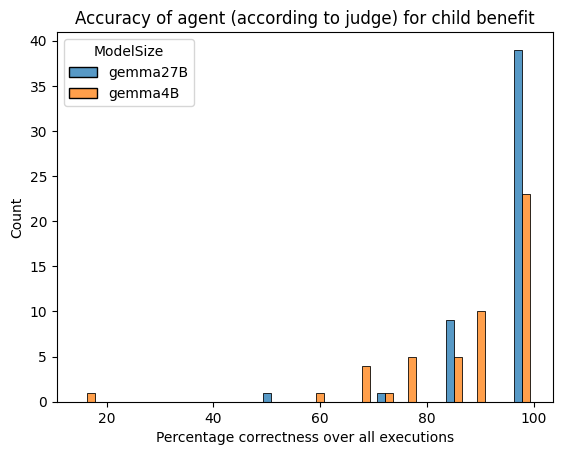

In [4]:
def get_success_rates_by_permutation(combined_df: pd.DataFrame) -> pd.DataFrame:
    df = (
        100
        * combined_df[combined_df[success_column] == True]
        .index.get_level_values(2)
        .value_counts()
        / combined_df.index.get_level_values(2).value_counts()
    )
    print(df.nsmallest(n=15))
    return df


def get_success_rates_by_permutation_model_size(combined_df: pd.DataFrame, test_cohort) -> pd.DataFrame:
    df = (
        100
        * combined_df[combined_df[success_column] == True]
        .index.droplevel(0)
        .droplevel(0)
        .value_counts()
        / combined_df.index.droplevel(0).droplevel(0).value_counts()
    )
    print(df.nsmallest(n=15))
    print(df.reset_index().set_index("permutation").value_counts())

    fig_name = "success_rates_by_permutation_model_size.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    ax = sns.histplot(
        df.reset_index(),
        x="count",
        hue="ModelSize",
        multiple="dodge",
        shrink=0.7,
        bins=20,
        common_bins=True,
    )
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")

    return df


success_rates_by_permutations = get_success_rates_by_permutation(
    combined_dfs
)
success_rates_by_permutation_model_sizes = (
    get_success_rates_by_permutation_model_size(
        combined_dfs, test_cohort
    )
)

count
 0.000000    23
 0.111111     6
 0.222222     4
 0.333333     3
 0.142857     3
-0.031746     2
-0.017857     2
 0.079365     1
 0.190476     1
 0.142857     1
-0.142857     1
 0.357143     1
 0.261905     1
-0.023810     1
Name: count, dtype: int64


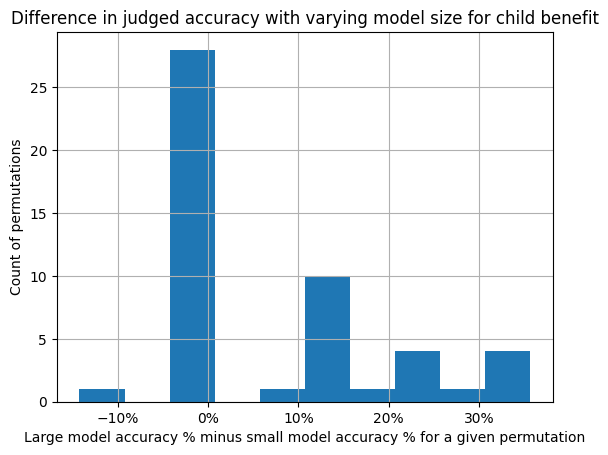

In [5]:
def get_large_model_improvements_by_permutation(
    combined_df_raw: pd.DataFrame,
    test_cohort
) -> pd.DataFrame:
    df = (
        combined_df_raw[
            (combined_df_raw[success_column] == True)
            & (combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["improved"])
        ]
        .index.get_level_values(2)
        .value_counts()
        / combined_df_raw[(combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["improved"])]
        .index.get_level_values(2)
        .value_counts()
    ) - (
        combined_df_raw[
            (combined_df_raw[success_column] == True)
            & (combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["baseline"])
        ]
        .index.get_level_values(2)
        .value_counts()
        / combined_df_raw[(combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["baseline"])]
        .index.get_level_values(2)
        .value_counts()
    )

    fig_name = "success_rates_by_permutation_model_size.improvement.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df.hist()
    ax = fig.get_axes()[0]
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(
        figure_annotations[test_cohort][fig_name]["xlabel"]
    )
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    fig.savefig(
        f"figures/{fig_name}.{test_cohort}.png"
    )
    print(df.value_counts())
    return df

large_model_improvement_by_permutations = (
    get_large_model_improvements_by_permutation(
        combined_dfs_raw, test_cohort
    )
)

Passed  eligible  not_eligible
True    True      False           440
        False     True            227
False   False     True             44
True    True      True             29
False   True      False            17
                  True              1
Name: count, dtype: int64


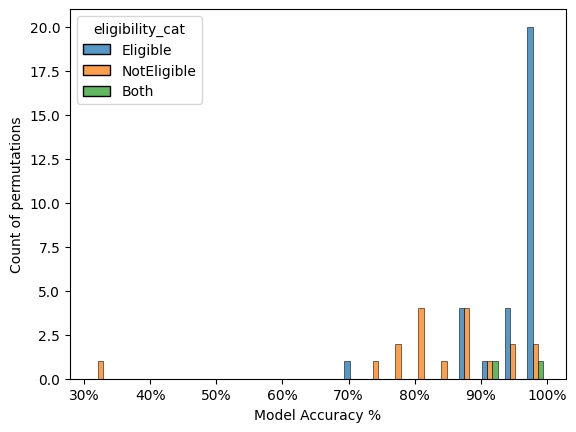

In [6]:
def get_success_rates_by_eligibility(
    success_rates_by_permutation: pd.DataFrame,
    eligibility_df: pd.DataFrame,
    test_cohort,
) -> pd.DataFrame:
    fig_name = "success_rates_by_eligibility.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df = eligibility_df.join(success_rates_by_permutation)
    df["eligibility_cat"] = df.apply(get_eligibility_case, axis=1)

    #  df = df.set_index(["eligible", "not_eligible"], append=True)
    #  df.hist()

    ax = sns.histplot(
        df,
        x="count",
        hue="eligibility_cat",
        multiple="dodge",
        shrink=0.7,
        bins=20,
        common_bins=True,
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100.0))

    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
    return df

print(
    combined_dfs_raw.value_counts(
        [success_column, "eligible", "not_eligible"]
    )
)
success_rates_by_eligibilitys = get_success_rates_by_eligibility(
    success_rates_by_permutations,
    eligibility_dfs,
    test_cohort,
)

/var/folders/b2/7k_brtrs25x6v118yqs3yt8m0000gp/T/ipykernel_6401/695135691.py:12: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df = df.reset_index().groupby(["eligibility_cat", "ModelSize"], axis=0).mean("count")


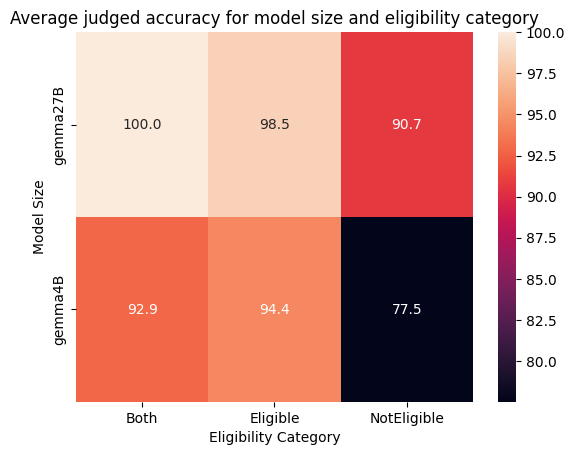

In [7]:
def get_success_rates_by_eligibility_model_size(
    success_rates_by_permutation_model_size: pd.DataFrame,
    eligibility_df: pd.DataFrame,
    test_cohort,
) -> pd.DataFrame:
    fig_name = "success_rates_by_eligibility.modelSize"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df = eligibility_df.join(success_rates_by_permutation_model_size)
    df["eligibility_cat"] = df.apply(get_eligibility_case, axis=1)

    df = df.reset_index().groupby(["eligibility_cat", "ModelSize"], axis=0).mean("count")

    ax = sns.heatmap(
        df.reset_index().pivot(index="ModelSize", columns="eligibility_cat", values="count"),
        annot=True,
        fmt=".1f"
    )

    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    #  ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100.0))
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )

    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
    return df

success_rates_by_eligibility_model_size = get_success_rates_by_eligibility_model_size(
    success_rates_by_permutation_model_sizes,
    eligibility_dfs,
    test_cohort,
)

In [8]:
#if __name__ == "__main__":
#    main(["child_benefit])

# **Test Execution Observations \- (Large/Small Foundation Model)**

# **Executive Summary**

Large models are more reliable than small ones, but the gain is incremental rather than step-change \- many Child Benefit scenarios are handled accurately by small models. The main advantage of large models is in complex and ineligibility cases, where they are better at explaining why someone is not eligible, not just deciding that they aren’t.

# **Methodology** 

## **1\. What were we trying to answer** 

* Can the small model be eliminated as a viable option for future investigations?   
* What is the measurable difference in outcome between interactions with an agent backed by a small model vs large   
* Is this approach of testing viable, does it provide consistent results?   
* Is the response time from the agent roughly consistent or does it vary?

## **2\. What we tested (plain English)** 

Service: Child Benefit 

Setup: 

* One agent-under-test, representing the agent which a user would be communicating with if this were a real service   
  * Backed by a foundation model, either small (4 billion parameters) or large (27 billion parameters).  
    * Both models were from the Google Gemma model family, to control for changes between model family and because the model family includes a smaller model (unlike Claude for instance)   
  * [Prompt provided to agent was simple instructions to hold a conversation with the user to determine their eligibility for child benefit](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/TechnicalHypotheses/Accuracy-ChildBenefit-v1.md)  
* For the purposes of testing, a judge agent to take on the role of user, and make judgements based on the responses of the agent-under-test   
* no personal data integrations  
* Eligibility criteria taken directly from [gov.uk](http://gov.uk) 

Scenarios: 50 scenarios devised by Gemini, by asking it to review the child benefit eligibility guidance and devise scenarios describing all the permutations of that guidance it could think of, representing realistic happy/sad paths 

Task: 

* Judge agent takes on persona described by a scenario, converses with agent under test, once agent under test has given an indication of eligibility   
* The judge agent compares that with the expected eligibility outcome described in the scenario.   
* If the outcome given by the agent under test matches the expected outcome described in the scenario, and the agent under test has not given any information which the judge agent considers to be incorrect, then the judge agent marks the result as a success.   
* Otherwise, the judge agent marks the result as a failure 

## **3\. What “good” looked like** 

* Agent-under-test does not make any statements which can be considered to be inaccurate with respect to the published government guidance on child benefit eligibility   
* Agent-under-test communicates an indication of eligibility which aligns with the published government guidance on child benefit eligibility 

## **4\. What happened** 

### **Headline result** 

* Large model performed better than small model overall  
* Small model results showed the highest rate of failure when the expected outcome of the scenario was ineligibility for child benefit   
* There were scenarios which both models found difficult to meet the criteria for success criteria (correct outcome and no erroneous statements). This suggests the consistency in the results and that this method of testing produces useful results   
* Response time was roughly similar, as judged by the overall execution time of the 50 test cases anecdotally 

### **Supporting Signals** 

**![][image1]**  
N.b. The category “Both” in the above graph is short for “Both Eligible and Not Eligible", which denotes complex cases where the outcome is either:

* Some of the adults in a family unit (i.e. one or more adults and one or more children) are eligible for child benefit, but some aren't.   
* Some of the children within the family unit (i.e. one or more adults and one or more children) meet the criteria for child benefit and some don't. 

Further analysis suggested (anecdotally) that where a result was deemed a failure, the eligibility outcome provided was correct in the majority of cases, and the reason a failure was reported was that the judge agent disagreed with some of the supporting information provided 

## **5\. What we learned** 

* The small model can't be eliminated as a viable option just yet.   
  1. Accuracy may improve with varying topology (i.e. working with multiple agents)  
* Biggest accuracy risks in judging reasoning for ineligibility   
* Testing approach yields results with some degree of consistency  
* Some scenarios were harder than others for both model sizes   
* A rough range of the accuracy rates which can be achieved 

## **6\. How this experiment shaped what we do next** 

* It suggests there is value in continuing on with testing approach   
* It suggests that child benefit scenarios are suitable for further testing   
* It suggests that it might be useful to have the judge agent categorize any failure in more granularity   
* It suggests that large models should be the focus for the next study (dealing with partial data and less than ideal responses) to understand what the best case accuracy might be 

## **7\. Artefacts & useful links** 

* [Scenarios tested](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/absolutely-not-main/prompts/manual/test_cases/child_benefit.md)   
* [Judge Prompt](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/absolutely-not-main/prompts/agents/Ancillary/EvaluationJudge.md)   
* [Agent Prompt](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/absolutely-not-main/prompts/agents/TechnicalHypotheses/Accuracy-ChildBenefit-v1.md) 

# **Appendix** 

## **Child Benefit** 

### **Overall Distribution of Failures over all Permutations** 

Definite clustering of failures; over 12 runs: 

* One permutation (46) had 7 failures   
* Five permutations (11,12,22,4,47) had 3 failures   
* Eight permutations had 2 failures   
* Ten permutations had 1 failure   
* Therefore 26 had 0 failures 

Suggests: 

* Some areas are either more ambiguous, or harder for Agent to understand   
* Consistency of failure suggests test cases are useful; if failures randomly distributed then it would show test cases useless at predicting failure 

### **Comparison of Rate of Occurrence of Failures Based on Model Size**

**![][image2]**  
On inspection of the above graph, we don't see an significant shift in accuracy with language model size for child benefit use cases 

* The minimum accuracy of the small model is lower than the minimum accuracy of the large model   
* The minimum accuracy of the large model is still around 50%, suggesting that there are some cases that the large model struggles with (in the eyes of the judge agent)

![][image3]  
The distribution of the difference in accuracy (large model accuracy % \- small model accuracy %) is as expected; the value is positive apart from one outlier, which suggests the large model is consistently outperforming the small model 

The outlier in question is test case 45 

The extent to which it is outperforming the small model is dependent on the test case, we can suggest that test cases that show significant improvement are more complex than those that don't, but with no way to easily quantify complexity in this context we can't prove that. 

From the graph, 28 cases out of 50 show no increase in accuracy moving from a small model to a large model

* Looking at value counts, 23 cases record a consistent 100% value for the small model   
  * There are 5 others whose average is within an acceptable percentage margin of error   
* This suggests that the cases which report no improvement in accuracy are those which report 100% accuracy against the small model   
* Accuracy value counts by model size

![][image4]  
There are a small number of permutations where the target outcome is split between eligible and not eligible , usually because it refers to two different people within a family unit, one of whom is eligible and one of whom is not eligible 

Inspecting the graph we see: 

* There are more cases with the target outcome of eligible than not eligible (31 vs 19\)   
* Even adjusting for this, a target outcome of not eligible reports lower accuracy than eligible 

Can suggest that this is because of issues with the model under test reporting why someone is ineligible rather than that they are ineligible 

* We could suggest that in complex cases the judge and the agent under test might disagree with the precise reasoning for someone being ineligible, and that neither of them are objectively correct

![][image5]  
We can see that the agent judged accuracy when the target outcome is Not Eligible is substantially better for large sized models than small 

* This refutes our earlier suggestion of there being subjective disagreement between the judge and the agent under test; if this were the case we wouldn't see a difference with model size


[image1]: <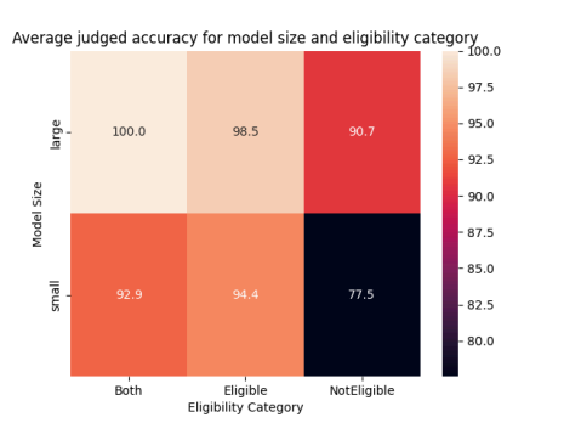>

[image2]: <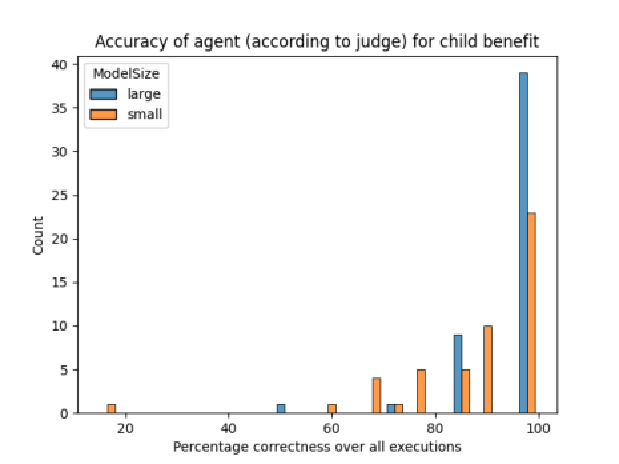>

[image3]: <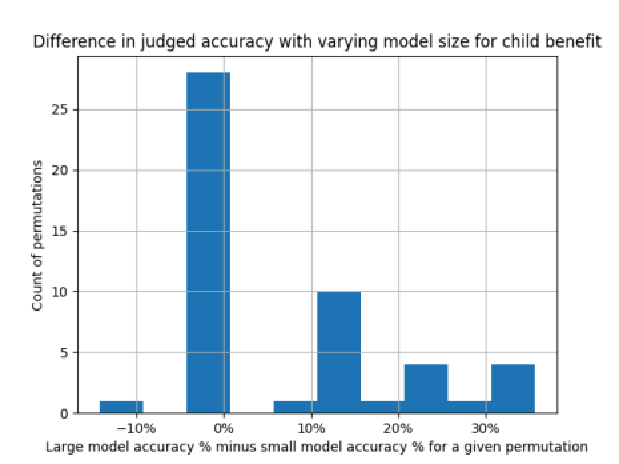>

[image4]: <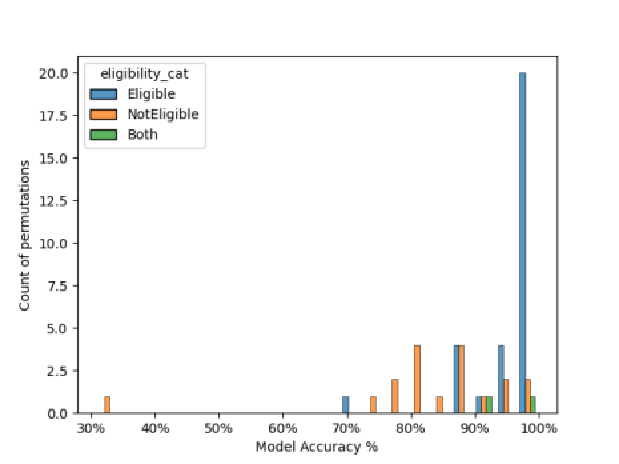>

[image5]: <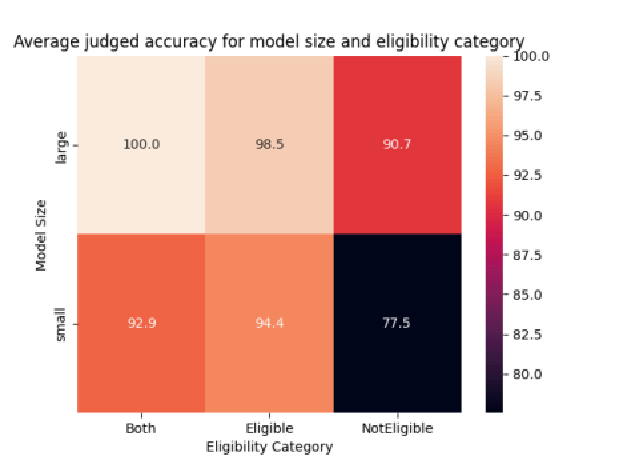>